In [17]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017")
db = client["sentinel_ops_db"]
#collection = db["ms_teams_freezes"]
collection = db["teams_freeze"]
# Define the query to filter the documents
query = {"device_country": "India", 'device_city': {'$nin': [None, ""]}}


# Define the projection to select specific fields (1 to include, 0 to exclude)
#projection = {"_id": 0, "event_date": 1, "device_os": 1, "device_city": 1, "number_of_freezes": 1 }
projection = {"_id": 0, "event_date": 1, "device_os": 1, "device_city": 1, "number_of_freezes": 1 }
# Execute the query and projection
filtered_documents = collection.find(query, projection)

import pandas as pd
data = pd.DataFrame(list(filtered_documents))

# Set the 'timestamp' column as the index of the DataFrame
data.set_index('event_date', inplace=True)
# Sort the DataFrame by the index (timestamp) if needed
data.sort_index(inplace=True)

# Group by the date part alone and count the number of crashes per day
# data['event_date'] = pd.to_datetime(data['event_date'])
# data['event_date'] = data['event_date'].dt.normalize()
# grouped_df = data.groupby(['event_date', 'device_os', 'device_city'])['number_of_freezes'].sum().reset_index()
grouped_df = data.groupby(['event_date'])['number_of_freezes'].sum().reset_index()
grouped_df['event_date'] = grouped_df['event_date'].dt.normalize()
#model_data = grouped_df
#print(f"model_data len: {len(model_data)}")

grouped_df.set_index('event_date', inplace=True)
grouped_df = grouped_df.asfreq('D')
grouped_df['number_of_freezes'] = pd.to_numeric(grouped_df['number_of_freezes'], errors='coerce')

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


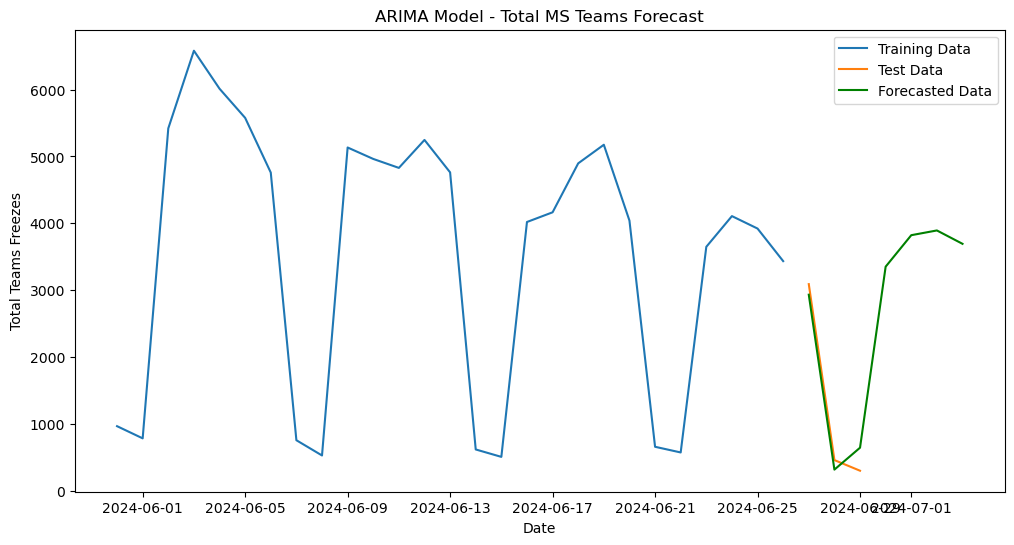

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_data, test_data = train_test_split(grouped_df, test_size=0.1, shuffle=False)

order=(7, 1, 1)

model = ARIMA(train_data, order=order)
model_fit = model.fit()

forecast = model_fit.forecast(steps=7)

forecast_df = forecast.to_frame()

#Plot graph of training set, Test set and Algorithm prediction on Test set
plt.figure(figsize=(12, 6))
#plt.plot(daily_crashes['total_crash'], label='Training Data')
plt.plot(train_data['number_of_freezes'].resample('D').sum(), label='Training Data')
plt.plot(test_data['number_of_freezes'].resample('D').sum(), label='Test Data')
plt.plot(forecast_df['predicted_mean'].resample('D').sum(), label='Forecasted Data', color='green')
plt.xlabel('Date')
plt.ylabel('Total Teams Freezes')
plt.title('ARIMA Model - Total MS Teams Forecast')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

test_data_flt = np.array(test_data.iloc[:,-1]).astype(float)

#forecast_flt = [float(item) for item in forecast]
forecast_flt = np.array(forecast).astype(float)

# Recalibrate the parameters using grid search (this is a simple example)
best_rmse = 0 # float('inf') #  float('inf') represents positive infinity. It's a special floating-point value that is greater than any other number. By setting best_rmse to float('inf'), 
# you are initializing it with a value that is guaranteed to be higher than any possible real root mean squared error (RMSE) value that could be calculated from your model predictions.
best_order = order

#weights = [0.3, 0.7]
# Calculate accuracy metrics
mse = mean_squared_error(test_data_flt, forecast_flt)
rmse = mse**0.5

if rmse > best_rmse:
    best_rmse = rmse
    best_order = order

print(f"rmse: {rmse}, best_rmse: {best_rmse}")

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = ARIMA(train_data, order=(p, d, q))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test_data))
                forecast_flt = np.array(forecast).astype(float)
                mse = mean_squared_error(test_data_flt, forecast_flt)
                rmse = mse**0.5
                print(f"p: {p}, d:{d}, q: {q}, rmse: {rmse}")
                if rmse > best_rmse:
                    best_rmse = rmse
                    best_order = (p, d, q)
                print(f"rmse: {rmse}, best_rmse: {best_rmse}")
            except:
                continue

print(f'Best ARIMA order: {best_order}')
print(f'Best RMSE: {best_rmse}')

# Refit the model with the best parameters
model = ARIMA(train_data, order=best_order)
model_fit = model.fit()
# Now you can use model_fit to make new predictions

forecast = model_fit.forecast(steps=steps)

predictions = forecast
actualValues = test_data

forecast_flt = np.array(forecast).astype(float)
mse = mean_squared_error(test_data_flt, forecast_flt)
rmse = mse**0.5
print(f'Fit RMSE: {rmse}')
